# Query Expansion
Query expansion consists of asking an LLM to produce a number of similar queries to a user query. We are then able to use each of these queries in the retrieval process, increasing the number and relevance of retrieved documents.


In [15]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

#HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

For this notebook we will use an InMemoryDocumentStore with document imported from wikipedia

In [16]:
import json

from typing import List, Optional
from haystack import Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.dataclasses import Document

from haystack.utils import Secret

## The Process of Query Expansion

First, let's create a `QueryExpander`. This component is going to be able to create a `number` (defaults to 5) of additional queries, similar to the original user query. It returns `queries` that has the original query + `number` of similar queries.

In [26]:
@component
class QueryExpander:

    def __init__(self, open_ai_key: str , prompt: Optional[str] = None, model: str = "gpt-4o-mini"):

        self.query_expansion_prompt = prompt
        self.model = model
        self.open_ai_key = open_ai_key
        if prompt == None:
          self.query_expansion_prompt = """
          You are part of an information system that processes users queries.
          You expand a given query into {{ number }} queries that are similar in meaning.

          Structure:
          Follow the structure shown below in examples to generate expanded queries.
          Examples:
          1. Example Query 1: "climate change effects"
          Example Expanded Queries: ["impact of climate change", "consequences of global warming", "effects of environmental changes"]

          2. Example Query 2: ""machine learning algorithms""
          Example Expanded Queries: ["neural networks", "clustering", "supervised learning", "deep learning"]

          Your Task:
          Query: "{{query}}"
          Example Expanded Queries:
          """
        builder = PromptBuilder(self.query_expansion_prompt)
        llm = OpenAIGenerator(model = self.model, api_key = self.open_ai_key)
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(queries=List[str])
    def run(self, query: str, number: int = 5):
        result = self.pipeline.run({'builder': {'query': query, 'number': number}})
        expanded_query = json.loads(result['llm']['replies'][0]) + [query]
        return {"queries": list(expanded_query)}

In [27]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

In [28]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

## Retrieval Without Query Expansion

In [29]:
embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)

In [30]:
retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("query_embedder", embedder)
retrieval_pipeline.add_component("embedding_retriever", retriever)

retrieval_pipeline.connect("query_embedder.embedding", "embedding_retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - embedding_retriever: ElasticsearchEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> embedding_retriever.query_embedding (List[float])

In [31]:
query = "Tolkien"
retrieval_pipeline.run({"query_embedder":{ "text": query}, "embedding_retriever":{"top_k": 3}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'embedding_retriever': {'documents': [Document(id=26f10b9b6260fd744f1a96e86080d0e204ab9b742c6a7c721e7aa79f86686898, content: 'Tolkien, Robert E. Howard, and H.P. ', meta: {'file_path': 'George_RR_Martin.txt', 'source_id': '1a887948105eaf886872a4f453d6b11e978d08ab88f93bed6ff71f4d318a2c7a', 'page_number': 1, 'split_id': 5, 'split_idx_start': 819}, score: 0.8348361, embedding: vector of size 384),
   Document(id=5c477bd7b54b6917fb41b14cdbc12e63ccf7e48ea695571d9638d65f4710442c, content: ' The success of The Hobbit marked Tolkien’s emergence as a prominent author, and his creation of Mid...', meta: {'file_path': '/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt', 'source_id': '95729082efb874f6adbd167b40d517e72164716f13b409e93ef114cbc81fcb5d', 'page_number': 1, 'split_id': 26, 'split_idx_start': 4073}, score: 0.82304543, embedding: vector of size 384),
   Document(id=479e353961c286fdec862662a8583cfd5999a38142443a94205422ba09d896a3, content: 'The

## Retrieval With Query Expansion

Now let's have a look at what documents we are able to retrieve if we include query expansion in the process. For this step, let's create a `MultiQueryElasticEmbeddingRetriever` that is able to use embedding retrieval for each (expanded) query in turn.

This component also handles the same document being retrieved for multiple queries and will not return duplicates.

In [32]:
@component
class MultiQueryElasticsearchEmbeddingRetriever:

    def __init__(self, retriever: ElasticsearchEmbeddingRetriever,  top_k: int = 3):
        self.retriever = retriever
        self.embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
        self.results = []
        self.ids = set()
        self.top_k = top_k

        self.pipeline = Pipeline()
        self.pipeline.add_component(name="embedder", instance=self.embedder)
        self.pipeline.add_component(name="retriever", instance=self.retriever)
        self.pipeline.connect("embedder", "retriever")
        

    def add_document(self, document: Document):
        if document.id not in self.ids:
            self.results.append(document)
            self.ids.add(document.id)

    @component.output_types(documents=List[Document])
    def run(self, queries: List[str], top_k: int = None):
        if top_k != None:
          self.top_k = top_k
        for query in queries:
          result = self.pipeline.run({"embedder": {'text':query}, "retriever": {"top_k": self.top_k}})
          for doc in result['retriever']['documents']:
            self.add_document(doc)
        self.results.sort(key=lambda x: x.score, reverse=True)
        return {"documents": self.results}

In [33]:
query_expander = QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN))

retriever = MultiQueryElasticsearchEmbeddingRetriever(ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 5))

expanded_retrieval_pipeline = Pipeline()
expanded_retrieval_pipeline.add_component("expander", query_expander)
expanded_retrieval_pipeline.add_component("embedding_retriever", retriever)

expanded_retrieval_pipeline.connect("expander.queries", "embedding_retriever.queries")

🚅 Components
  - expander: QueryExpander
  - embedding_retriever: MultiQueryElasticsearchEmbeddingRetriever
🛤️ Connections
  - expander.queries -> embedding_retriever.queries (List[str])

In [34]:
expanded_retrieval_pipeline.run({"expander": {"query": query}}, include_outputs_from=["expander"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'embedding_retriever': {'documents': [Document(id=bd9a33cafb670f9e79c4c24ef3d76afcf75f0ca9cac23f6ef38916c77531a025, content: '
   
   Despite his achievements, Tolkien faced criticism from some literary circles that dismissed fantas...', meta: {'file_path': '/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt', 'source_id': '95729082efb874f6adbd167b40d517e72164716f13b409e93ef114cbc81fcb5d', 'page_number': 1, 'split_id': 44, 'split_idx_start': 6808}, score: 0.8746135, embedding: vector of size 384),
   Document(id=9f1b29178239d94a77c382f0fe4e3c720212248815e8746132c6dc6471aab535, content: 'Despite his achievements, Tolkien faced criticism from some literary circles that dismissed fantasy ...', meta: {'file_path': 'tolkien.txt', 'source_id': 'df36a6e19f29965789bd0aec4f23afb6cfe4436938474a5242b204a2fc777eb6', 'page_number': 1, 'split_id': 42, 'split_idx_start': 6810}, score: 0.8746135, embedding: vector of size 384),
   Document(id=cab8dca864050a

## Query Expansion for RAG

### RAG without Query Expansion

In [35]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.

You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN))

rag_pipeline = Pipeline()
rag_pipeline.add_component("embedder", embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt", prompt_builder)
rag_pipeline.add_component("llm", llm)

rag_pipeline.connect("embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt.documents")
rag_pipeline.connect("prompt", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [36]:
query = "Tolkien"
res = rag_pipeline.run({"embedder": {"text": query}, "retriever": {"top_k": 3}}, include_outputs_from=["retriever"])
rich.print(res["llm"]["replies"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[
    'The retrieved documents highlight the significance of J.R.R. Tolkien as a prominent author, particularly 
noting his emergence in the literary world following the success of "The Hobbit." This work not only established 
his reputation but also set the stage for his later creations. Tolkien is often discussed alongside other notable 
authors such as Robert E. Howard and H.P. Lovecraft, indicating his influence in the realm of fantasy literature 
(Document id: 26f10b9b6260fd744f1a96e86080d0e204ab9b742c6a7c721e7aa79f86686898).\n\nIn more detail, the success of 
"The Hobbit" is described as a pivotal moment in Tolkien\'s career, leading to his recognition and the eventual 
development of the richly imagined world of Middle-earth, which has captivated readers for generations (Documents 
id: 5c477bd7b54b6917fb41b14cdbc12e63ccf7e48ea695571d9638d65f4710442c and 
479e353961c286fdec862662a8583cfd5999a38142443a94205422ba09d896a3).\n\nThis information indicates Tolkien’s 
influential role in the genre and his lasting legacy in literature.'
]

### RAG with Query Expansion

In [39]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.

You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
expander = QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN))
query_retriever = MultiQueryElasticsearchEmbeddingRetriever(ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 5))
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN))

query_expanded_rag_pipeline = Pipeline()
query_expanded_rag_pipeline.add_component("expander", expander)
query_expanded_rag_pipeline.add_component("retriever", query_retriever)
query_expanded_rag_pipeline.add_component("prompt", prompt_builder)
query_expanded_rag_pipeline.add_component("llm", llm)

query_expanded_rag_pipeline.connect("expander.queries", "retriever.queries")
query_expanded_rag_pipeline.connect("retriever.documents", "prompt.documents")
query_expanded_rag_pipeline.connect("prompt", "llm")

🚅 Components
  - expander: QueryExpander
  - retriever: MultiQueryElasticsearchEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - expander.queries -> retriever.queries (List[str])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

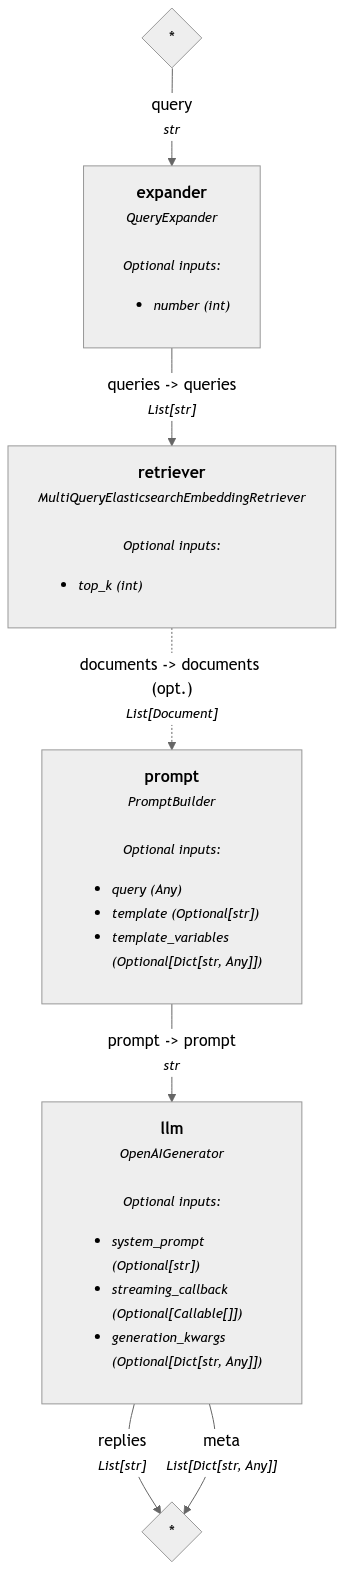

In [40]:
query_expanded_rag_pipeline.show()

In [46]:
query = "Tolkien"
res = query_expanded_rag_pipeline.run({"expander": {"query": query}, "retriever": {"top_k": 3}}, include_outputs_from={"retriever", "expander"})

rich.print(res['llm']['replies'])
print("Expander: ", res['expander'])
print("Retriver: ", res['retriever'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[
    'J.R.R. Tolkien is celebrated for his remarkable contributions to the fantasy genre, particularly through his 
creation of the intricate world of Middle-earth. His dedication to constructing a fully realized universe, complete
with its own languages, cultures, and histories, distinguishes him from other authors. This level of detail is 
exemplified in his novels, notably "The Hobbit" and "The Lord of the Rings," which not only captivated readers but 
also set the foundation for modern fantasy storytelling (Document 
id=12d58a5cd7dc9c2049caa0826faf2a766b66f76b524855c7565f43ee94d2feaf; Document 
id=4d01aa35de402ba9390ae28b9e8fd9432251812b7a3591bae3b5e2cd8ed14c8e).\n\nThe success of "The Hobbit," published in 
1937, marked Tolkien\'s emergence as a significant literary figure and introduced readers to the enchanting world 
of Middle-earth (Document id=5c477bd7b54b6917fb41b14cdbc12e63ccf7e48ea695571d9638d65f4710442c; Document 
id=3344c84fdd11e11ab791cb4e768c3c2e9cc8a548bda1f92fa0d2bfabf67e02bb). Despite facing criticism from some literary 
circles who dismissed fantasy as less serious, Tolkien persisted in his craft, ultimately gaining recognition as a 
master storyteller and myth-maker (Document id=bd9a33cafb670f9e79c4c24ef3d76afcf75f0ca9cac23f6ef38916c77531a025; 
Document id=26a81bf514c9ef89416fcd0be97cffadf9d906200bfb57edc85b21eeadbd764b).\n\nIn addition to his novels, 
Tolkien also engaged with his audience through essays and letters, discussing his creative process and the 
influences on his work (Document id=cab8dca864050a6088d187555505f8700bdc78fd0ccdfbc85d54f37a3b5622cb; Document 
id=a71ed6b1521657afac5e2858c2a2fd29a57b063726a76996366578ff0dae859d). His legacy continues through various 
adaptations of his works and the lasting impact he has had on the fantasy genre.'
]

Expander:  {'queries': ['J.R.R. Tolkien', 'Middle-earth', 'The Lord of the Rings', 'Hobbit author', 'fantasy literature by Tolkien', 'Tolkien']}
Retriver:  {'documents': [Document(id=12d58a5cd7dc9c2049caa0826faf2a766b66f76b524855c7565f43ee94d2feaf, content: ' This dedication to creating a fully realized world set Tolkien apart from other fantasy authors and...', meta: {'file_path': '/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt', 'source_id': '95729082efb874f6adbd167b40d517e72164716f13b409e93ef114cbc81fcb5d', 'page_number': 1, 'split_id': 34, 'split_idx_start': 5447}, score: 0.8846303, embedding: vector of size 384), Document(id=4d01aa35de402ba9390ae28b9e8fd9432251812b7a3591bae3b5e2cd8ed14c8e, content: 'This dedication to creating a fully realized world set Tolkien apart from other fantasy authors and ...', meta: {'file_path': 'tolkien.txt', 'source_id': 'df36a6e19f29965789bd0aec4f23afb6cfe4436938474a5242b204a2fc777eb6', 'page_number': 1